In [11]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.models import load_model
from keras.utils import plot_model
from scipy import stats as ss
from scipy import optimize
from scipy.interpolate import griddata
from IPython.display import Image, display

In [3]:
def create_model_2d(n_samples, out_dense_1, out_dense_2, depth, kernel_size, n_kernels):      
    # Number of neurons for the dense layers.
    n_channels = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_channels * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_channels:",
          n_channels, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_channels):
        layer_1.append(Dense(out_dense_1 * depth, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)

    reshape = Reshape(target_shape=(out_dense_total, depth, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, depth), strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    reshape_after_avg = Reshape(target_shape=(n_samples,))(avg)
    print("Shape after reshape:", reshape.shape)    
    
    model = keras.Model(model, reshape_after_avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [4]:
def gen_data(n_data, n_samples):
    mu = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_data)
    sd = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_data)
    x = np.linspace(MIN_X, MAX_X, n_samples)
    # TODO: Loss function plotting; allow for different loss functions.
    # Make sure that distributions don't get off the grid (truncated)

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_sampled

In [125]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA = 1000000
N_SAMPLES = 150 # TODO Rename to grid_size

# NN Settings.
OUT_D_1 = 10
OUT_D_2 = 40
DEPTH = 25
K_SIZE = 20 # TODO Consider adding this as a fraction of the grid size
N_K = 15

out_dense_1: 10 
out_dense_2: 40 
n_channels: 3 
out_dense_total: 120 
kernel_size: 21 
n_kernels: 15
Shape after input: (?, 2)
Shape after concat: (?, 40, 25, 3)
Shape after reshape: (?, 120, 25, 1)
Shape after avg: (?, 100, 1)
Shape after reshape: (?, 120, 25, 1)


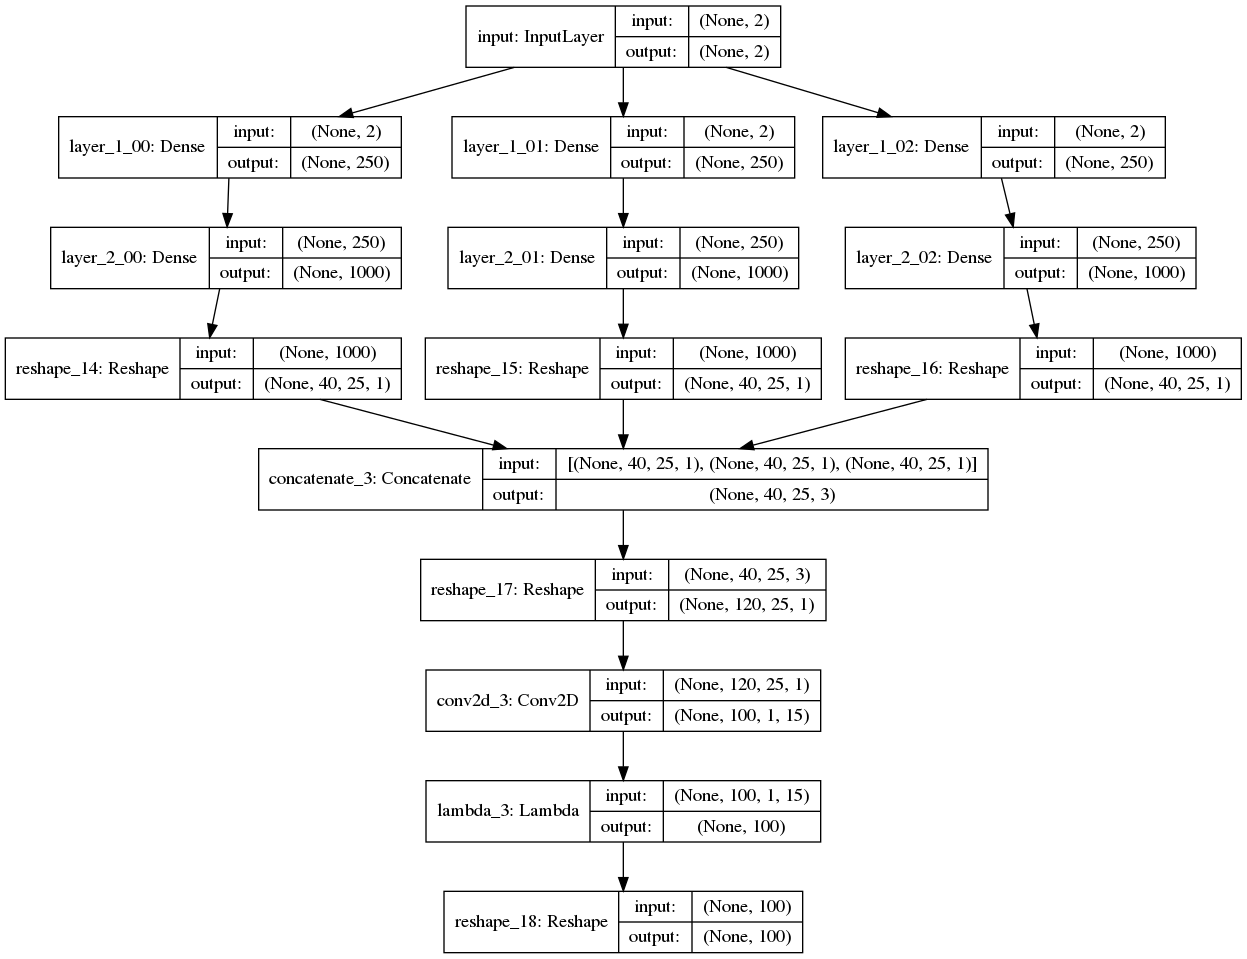

Epoch 1/5
200000/200000 [==============================] - 14s 71us/step - loss: 8.4630
Epoch 2/5
200000/200000 [==============================] - 15s 77us/step - loss: 0.2697
Epoch 3/5
200000/200000 [==============================] - 15s 76us/step - loss: 0.2152
Epoch 4/5
200000/200000 [==============================] - 17s 83us/step - loss: 0.1602
Epoch 5/5
200000/200000 [==============================] - 17s 87us/step - loss: 0.1487


In [126]:
model = create_model_2d(N_SAMPLES, OUT_D_1, OUT_D_2, DEPTH, K_SIZE, N_K)
model.compile(optimizer='adam', loss='mean_squared_error')

params, x_sampled = gen_data(N_DATA, N_SAMPLES)
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=5)

In [127]:
# Only use this when we actually trained a good model...
#model.save('model.h5')

In [128]:
predictions = model.predict(params)

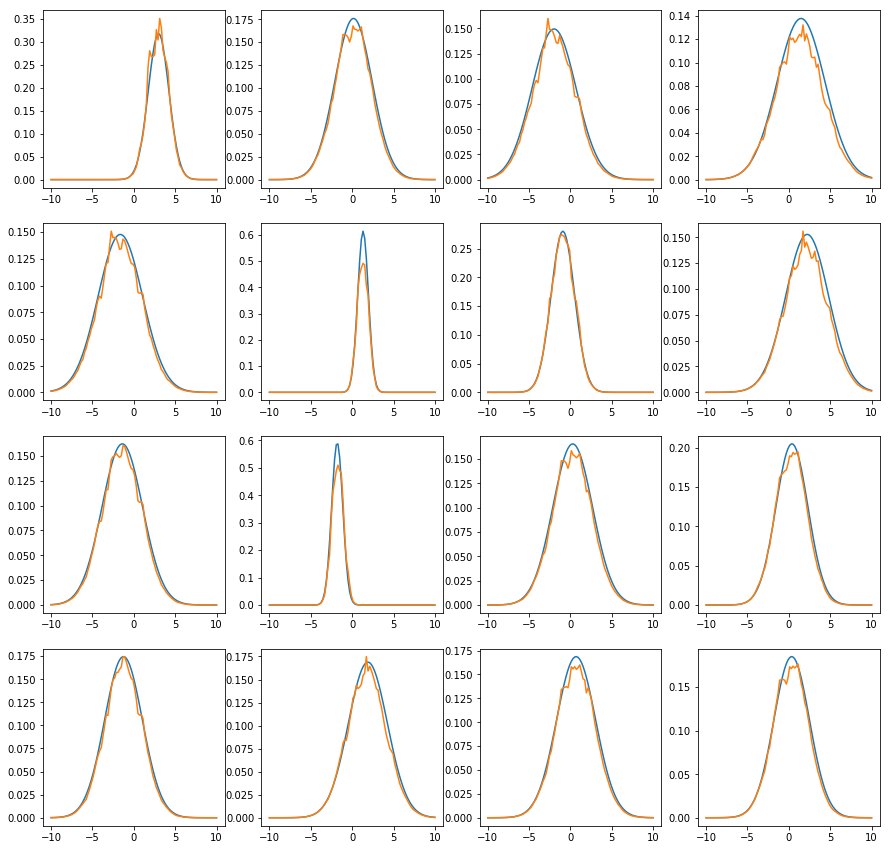

In [129]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(predictions[ix, :]))

In [130]:
# Log likelihood function.
def log_likelihood(model, theta, x_grid, x):
    if np.abs(theta[0]) > 3 or theta[1] < 0.5 or theta[1] > 3:
        return -1e9
    
    theta = np.atleast_2d(theta)
    likelihood_on_grid = model.predict(theta).T
    
    points = np.atleast_2d(x_grid).T

    ll = griddata(x_grid, likelihood_on_grid, x, fill_value=-1e9)
    
    return ll

In [131]:
def get_summed_ll(model, theta, x_grid, x):
    return np.sum(log_likelihood(model, theta, x_grid, x))

In [132]:
def estimate_mu(model, x_grid, x):
    return optimize.minimize(lambda theta: -get_summed_ll(model, theta, x_grid, x), 
                             x0=[0, 1], 
                             method='Nelder-Mead').x[0:2]

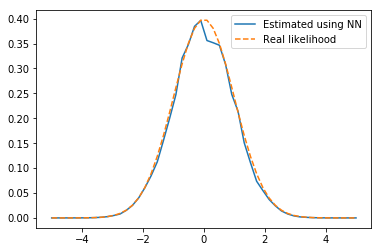

In [133]:
p = np.array([0, 1]) # Mean 0, SD 1.
pts = np.linspace(MIN_X, MAX_X, N_SAMPLES)
x_test = np.linspace(-5, 5)
ll = log_likelihood(model, p, pts, x_test)
    
plt.plot(x_test, np.exp(ll), label='Estimated using NN')
plt.plot(x_test, ss.norm().pdf(x_test), ls='--', label='Real likelihood')
plt.legend()

In [134]:
x_grid = np.linspace(MIN_X, MAX_X, N_SAMPLES)
x = ss.norm(0.8, 0.6).rvs(50)

In [135]:
est = estimate_mu(model, x_grid, x)
print('Mu:', est[0], 'Sigma:', est[1])

Mu: 1.0871872364271706 Sigma: 0.7659341433119551


In [136]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from itertools import product

In [168]:
pars = product(np.linspace(5, 100, n_ns, dtype=int), np.arange(n_runs), zip(mus, sigmas))
for n, trial, params in pars:
    print(n, trial, params[0], params[1])

5 0 1.9913967145445444 2.9452049095315753
5 0 0.5254502832194499 1.968747787958205
5 0 -2.211478824953262 0.627745339303818
5 0 -0.3356537978993823 2.0947301608847138
5 0 -1.3095123178167603 1.649177267147396
5 0 -1.0450266278713274 1.9421827104842035
5 0 -1.9656801732166536 1.4037387193086752
5 0 -2.4203819493565093 1.300869157834664
5 0 1.9274993088047268 0.5468108901216193
5 0 -0.742479279897803 1.0415106767341171
5 0 2.4413800650831785 2.6078028373782813
5 0 -0.419280581326809 0.6318493966068359
5 0 -2.967949317474731 0.5133119002090085
5 0 -1.1519987038549424 1.114732111230547
5 0 1.8309113448834156 0.7580805608226944
5 0 0.5436353683591157 2.8220384013798907
5 0 -0.23234594501822414 2.5353086024433833
5 0 -2.399768321092176 0.5880402850176032
5 0 -1.138860868344791 2.6430468145088932
5 0 -0.514798220745321 2.2645402261839562
5 1 1.9913967145445444 2.9452049095315753
5 1 0.5254502832194499 1.968747787958205
5 1 -2.211478824953262 0.627745339303818
5 1 -0.3356537978993823 2.0947301

In [194]:
df = []
df1 = []

n_ns = 10
n_runs = 5
n_params = 20

mus = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_params)
sigmas = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_params)

pars = product(np.linspace(5, 100, n_ns, dtype=int), np.arange(n_runs), zip(mus, sigmas))

with tqdm(total=n_ns*n_params*n_runs) as t:
    for n, trial, params in pars:
        test_data = ss.norm(params[0], params[1]).rvs(n)

        params_est = estimate_mu(model, x_grid, test_data)
        mu_estimate = params_est[0]
        sigma_estimate = params_est[1]
        
        ml_mu_estimate = np.mean(test_data)
        ml_sigma_estimate = np.std(test_data)

        df.append({'n':n,
                   'trial':trial,
                   'mu':params[0],
                   'mu_nn':mu_estimate,
                   'mu_ml':ml_mu_estimate})
        
        df1.append({'n':n,
                    'trial':trial,
                    'sigma':params[1],
                    'sigma_nn':sigma_estimate,
                    'sigma_ml':ml_sigma_estimate})
        t.update()
    
df = pd.DataFrame(df)
df1 = pd.DataFrame(df1)

In [196]:
df_ = df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')

In [197]:
df1_ = df1.melt(id_vars=['sigma', 'n', 'trial'], var_name='method', value_name='estimate')

In [198]:
tmp = df_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')

In [199]:
tmp1 = df1_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['sigma'])[0]).to_frame('r')

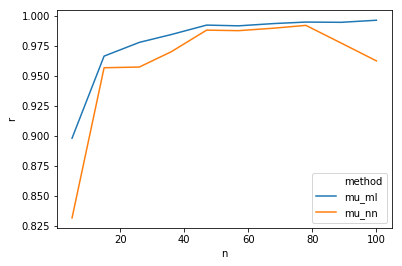

In [200]:
sns.lineplot('n', 'r', 'method', data=tmp.reset_index())

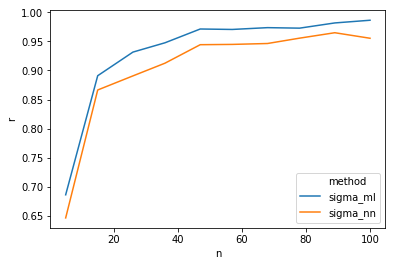

In [201]:
sns.lineplot('n', 'r', 'method', data=tmp1.reset_index())